# Identify parameters for thresholding-based segmentation (pyroots_analysis())

## Contents and Introduction
This notebook is to help identify the parameters needed to successfully analyze images for roots, hyphae, and other stringy things in medicore images. It walks through the functions in the order presented in ``pyroots.pyroots_analysis`` and gives tips for how to set parameters. At the end, you can use it to write``analysis_parameters.py``. 
Parameters to change are show within blocks of hashtags, like:
```
################################################################
change_this_parameter = to_this
################################################################
```

You shouldn't need to change much else. Regardless, don't forget to save a copy of this notebook in it's original state!!

### Contents
1. Load the image and equalize brightness
2. Identify colorspace and select bands
3. Set threshold parameters
4. Apply a mask
5. Set noise filtering parameters
6. Skeletonize
7. Set geometry filtering parameters
8. Summarize

## 1. Load the image
All you need to do is identify the (full) directory to the image, and it's filename. Setting the parameters like this makes it easier to change later.

/home/patrick/Programs/scikit-image/skimage/external/tifffile/tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


Image Dimensions [length, width, bands]: [5936, 4528, 3]


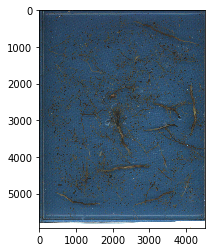

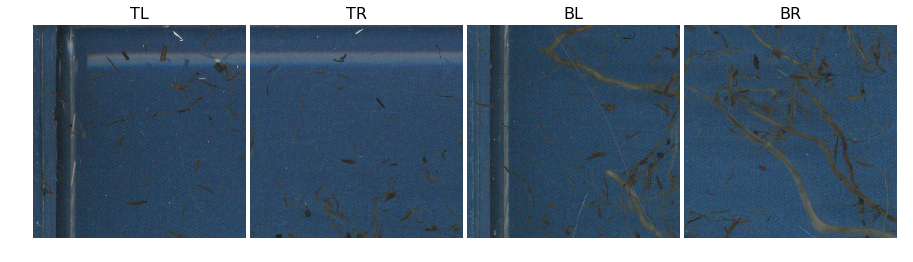

In [1]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Cloud/Thesis/MS2 - Carbon Inputs/Analysis/Pyroots Setup/RLD/Test Images/2014"
file_in = "101R0_1.TIF"

# Zoom to these coordinates
zoom = {'xmin' : 1000,
        'xmax' : 1700,
        'ymin' : 000,
        'ymax' : 700}
zoom1 = {'xmin' : 000,
         'xmax' : 700,
         'ymin' : 1000,
         'ymax' : 1700}
zoom2 = {'xmin' : 450,
         'xmax' : 600,
         'ymin' : 1250,
         'ymax' : 1400}
zoom3 = {'xmin' : 0,
         'xmax' : 700,
         'ymin' : 0,
         'ymax' : 700}
zoom4 = {'xmin' : 1000,
         'xmax' : 1700,
         'ymin' : 1000,
         'ymax' : 1700}
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_int, restoration
import pyroots as pr
import numpy as np
from scipy import ndimage
import os

image = io.imread(os.path.join(dir_in, file_in))

print("Image Dimensions [length, width, bands]: " + str([i for i in image.shape]))

img = image
plt.imshow(img)
zoom_list = [zoom3, zoom, zoom1, zoom4]
pr.multi_image_plot([pr._zoom(img, **i) for i in zoom_list], ['TL', 'TR', 'BL', 'BR'])

In [3]:
def equalize_exposure(image, kernel_size, min_object_size=501, dark_objects=True, bins=256):
    
    # Housekeeping
    img = image.copy()
    
    img_in = img.copy()
    img_mean = np.mean(img)
    
    # mean filter kernel
    kernel = morphology.disk(int(kernel_size/2))
    
    # identify objects to ignore
    objects = filters.threshold_adaptive(img, block_size = 501, offset = 0.01*img.max())
    if dark_objects == True:
        objects = ~objects
    
    objects = morphology.remove_small_objects(objects, min_size = min_object_size)

    # find correction array based on means
    correction = filters.rank.mean(img, selem=kernel, mask = ~objects)
    correction = filters.gaussian(correction, kernel_size)*(bins-1)
    out = img_in + (img_mean - correction)
    out = exposure.rescale_intensity(out, out_range=(0,1))
#     out = np.array(out, dtype=np.uint8)
    
    return(out)

# x = equalize_exposure(eq[0], kernel_size=151)
# x1 = equalize_exposure(x, kernel_size=151)
# x = x-means[0]
# x = eq[0] + x
# pr.multi_image_plot([eq[0], x, x1], ['original', 'equalized', '2x'])

In [2]:
########################################################################################
equalize_exposure = {'iterations'      : 1,
                     'kernel_size'     : 151,
                     'min_object_size' : 500,
                     'dark_objects'    : True,
                     'stretch'         : False
                    }
########################################################################################

eq = pr.img_split(image.copy())

means = [pr.equalize_exposure(i, **equalize_exposure) for i in eq]
means1 = [pr.equalize_exposure(i) for i in means]
ex_eq = np.zeros(image.shape)
for i in range(3):
    ex_eq[:, :, i] = means[i]
    
ex_eq1 = np.zeros(image.shape)
for i in range(3):
    ex_eq1[:, :, i] = means1[i]

pr.multi_image_plot([image, ex_eq, ex_eq1], ['original', 'adjusted', '2x'])

pr.multi_image_plot([ex_eq1[:,:,i] - ex_eq[:,:,i] for i in range(3)], ['r','g','b'])
img = means
pr.multi_image_plot(img, ['r','g','b'])
img = means1
pr.multi_image_plot(img, ['r','g','b'])

/home/patrick/Programs/scikit-image/skimage/filters/thresholding.py:221: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/home/patrick/Programs/scikit-image/skimage/filters/thresholding.py:223: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
/home/patrick/Programs/scikit-image/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/patrick/Programs/scikit-image/skimage/filters/thresholding.py:221: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, meth

KeyboardInterrupt: 

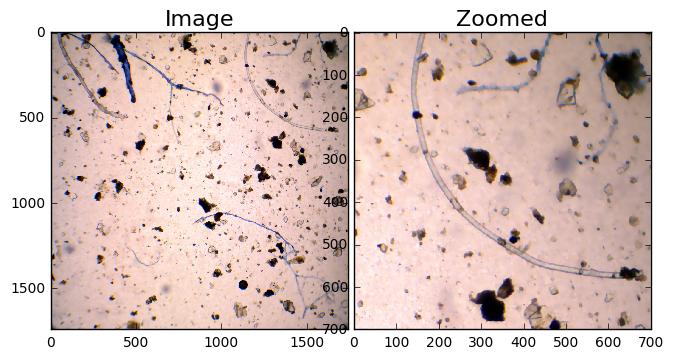

In [5]:
%matplotlib inline

########################################################################################
# Zoom to these coordinates
zoom = {'xmin' : 1000,
        'xmax' : 1700,
        'ymin' : 000,
        'ymax' : 700}
########################################################################################

img = image
pr.multi_image_plot([img, pr._zoom(img, **zoom)],    # list of images to show
                    ["Image", "Zoomed"], # Titles
                    axis = "on")         # for convenience (default='off')

## 2. Identify Colorspace
What colorspace to use? Options include LAB, HSV, and CMY in addition to RGB. Choose the one that allows the objects to "pop".

Once decided, note whether the interesting objects appear dark on a light background, or light on a dark background. 

#### If your objects are stained, pay special attention that the stain takes a different value than things like residue bits!

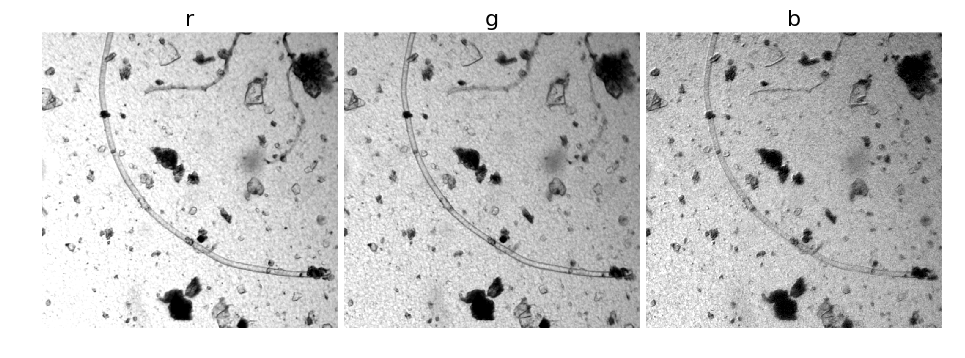

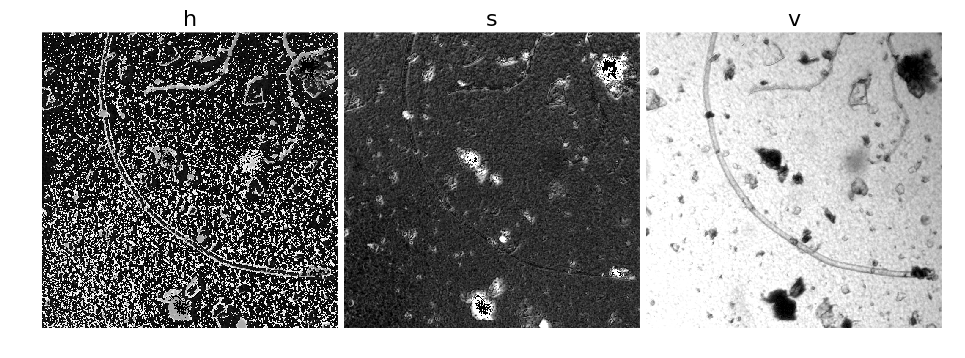

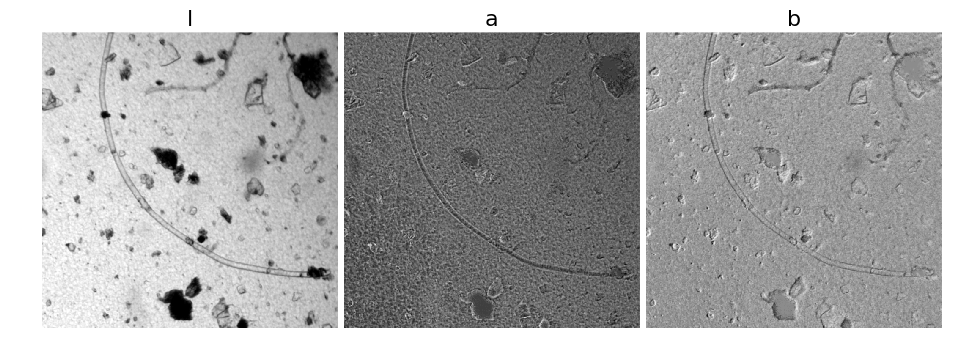

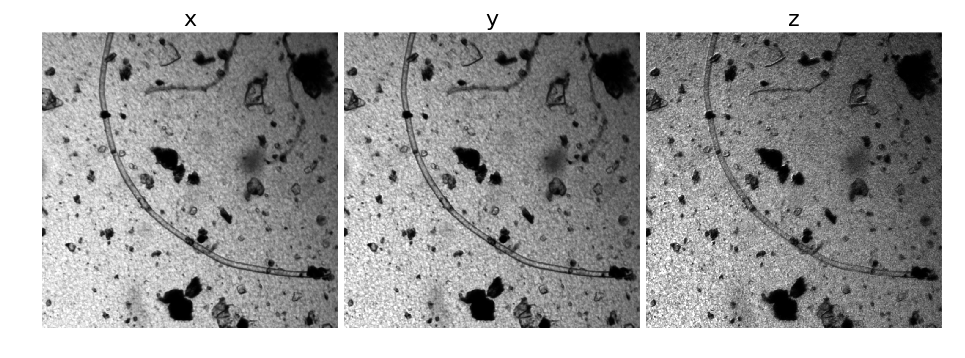

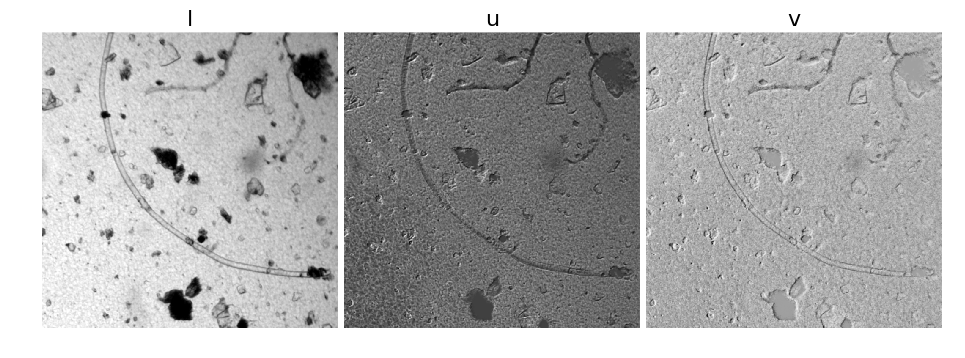

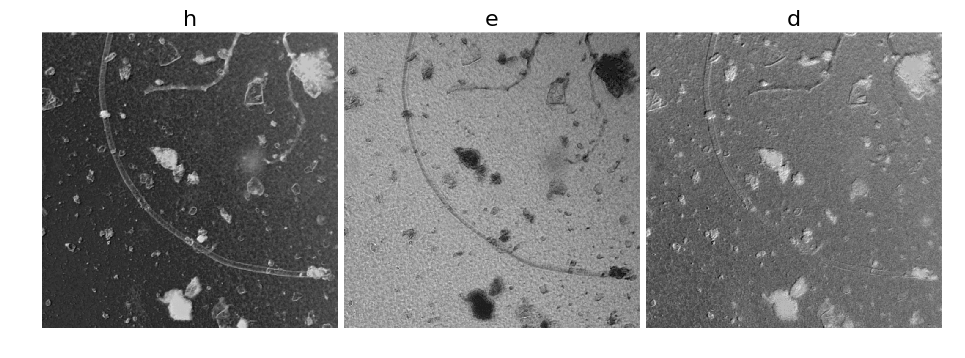

[None, None, None, None, None, None]

In [3]:
####################################################
colorspaces = ['rgb','hsv','lab','xyz','luv', 'hed']  # add or remove whatever you're curious about. See skimage.color.rgb2*()
####################################################

[pr.band_viewer(image, i, zoom_coords = zoom) for i in colorspaces]

Here, the "U" band of LUV looks best. Hyphae are both clear and sharp, and non-blue things are less obvious than in other bands of other colorspaces. R of RGB and V of HSV are also OK. 
We also note that the hyphae are dark objects on a light background (as opposed to the H band of HSV).

If we want to remove some of the dirt bits we can run a second threshold on a different band. B of RGB looks promising for this if the block size is large - hyphae don't stand out too much, but all of the dirt does!

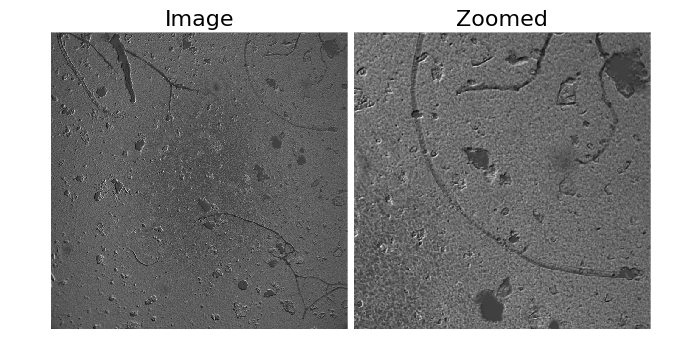

In [10]:
#########################################################
# Fill out analysis_parameters.py
colorspace = "luv"
analysis_bands = [1]  # U
light_on_dark = False  # dark hyphae
##########################################################

band = image
if colorspace is not "rgb":
    band = getattr(color, 'rgb2' + colorspace)(band)  # call rgb2luv(image)
band = pr.img_split(band)    # semi-unnecessary function
band = [band[n] for n in analysis_bands]


# plot one of the bands
[pr.multi_image_plot([i, pr._zoom(i, **zoom)], ["Image", "Zoomed"]) for i in band]

band = exposure.rescale_intensity(band[0], out_range = (0, 255))

## Try smoothing then sharpening

In [8]:
smooth = exposure.equalize_adapthist(band[0], kernel_size = band.shape[0]/4)
plt.imshow(adapt_hist, cmap = "gray")

ValueError: Images of type float must be between -1 and 1.

In [186]:
%psource exposure.equalize_adapthist

## 3. Set Thresholding Parameters
Next, we need to set thresholding parameters. This uses ``scipy.ndimage.filters.threshold_adaptive`` to separate objects from the background. It isn't perfect on it's own, but should get us close.
The function sets a variable threshold based on a neighborhood. It finds the mean and standard deviation of a region, and then marks the center pixel of that region as either ``True`` or ``False`` based on whether the value of that pixel is above the mean + standard deviation + an offset. The parameters to set are:
* ``block_size`` = the size of the neighborhood. Must be odd. Start with ``191``. 
* ``offset`` = additional values above a set threshold. Start with ``5``. This has a strong effect on filtering.
* ``param`` = base calculation of the threshold. The function suggests ``(block_size-1)/6``. This has a minor effect on filtering.

The goal is not to have a perfectly clean image, but rather one where the objects are more or less fully defined and also clear of extraneous objects. We'll remove noise and dirt later.

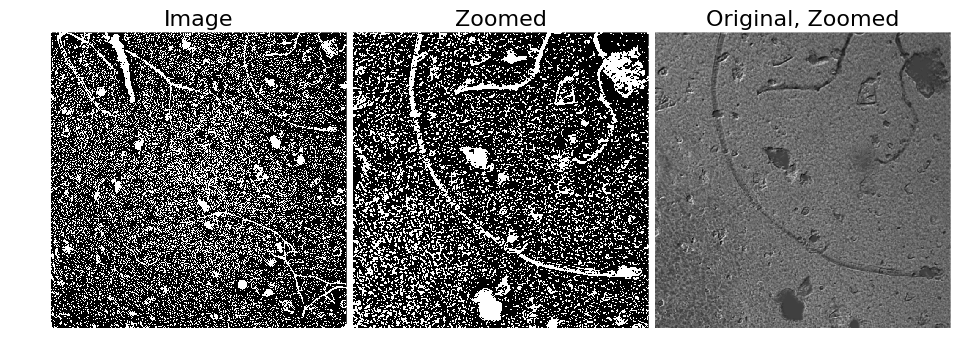

In [19]:
#################################################################################
threshold_params = {'block_size' : 191,
                    'offset'     : 6,
                    'param'      : ((191-1)/6)}
#################################################################################

# threshold = [filters.threshold_adaptive(n, **threshold_params) for n in band]
threshold = ~filters.threshold_adaptive(band, **threshold_params)
# threshold = threshold[0]

img = threshold
pr.multi_image_plot([img, pr._zoom(img, **zoom), pr._zoom(band, **zoom)], ["Image", "Zoomed", "Original, Zoomed"])

## 4. Apply a mask
Because this is a microscope image and the edges are blurry, I want to select the center 3/4 of the picture with a circle mask.

This function, ``pyroots.circle_mask``, takes an optional list of parameters defining the major and minor axes of an ellipse.

Apply this AFTER the thresholding to avoid the mask interfering with the thresholding algorithm.

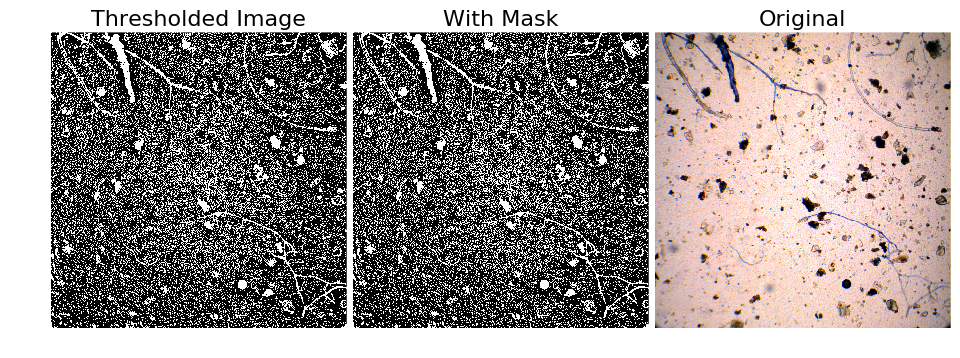

In [23]:
############################################################################
percentage_x = 115 # percentage of the image width, height you want to cover
percentage_y = 115
offset_x = 0        # offset center of the ellipse this many pixels
offset_y = 0
mask = True        # Do you even want a mask?
############################################################################

mask = pr.ellipse_mask(threshold, percentage_x, percentage_y, offset_x, offset_y)

if mask is True: mask = threshold * mask
else: mask = threshold

img = mask
pr.multi_image_plot([threshold, mask, image], ["Thresholded Image", "With Mask", "Original"])

## 4b. Remove small holes

[[ 0.  1.  1.  1.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  0.]]


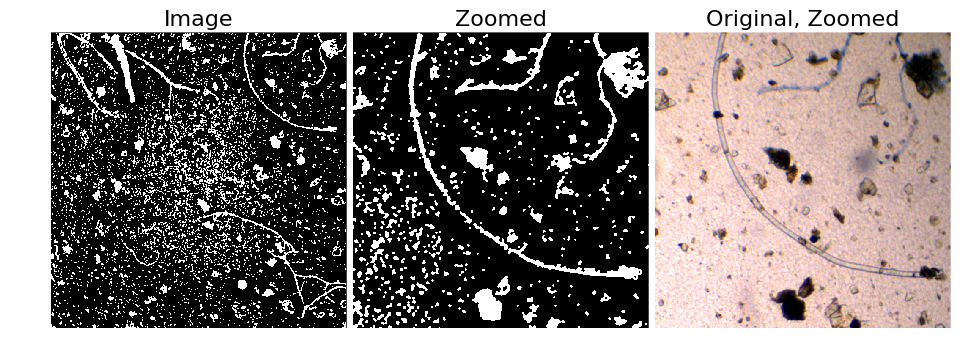

In [26]:
######################################################################
MIN_SIZE = 45
######################################################################
circle = np.zeros((5, 5))
circle[draw.circle(2, 2, 2.5)] = 1
print(circle)


mask = ndimage.filters.median_filter(threshold, footprint = circle)
mask = morphology.binary_closing(mask, selem = circle)
mask = ndimage.filters.median_filter(mask, footprint = circle)
mask = morphology.binary_opening(mask, selem = circle)

img = mask
pr.multi_image_plot([img, pr._zoom(img, **zoom), pr._zoom(image, **zoom)], ["Image", "Zoomed", "Original, Zoomed"])

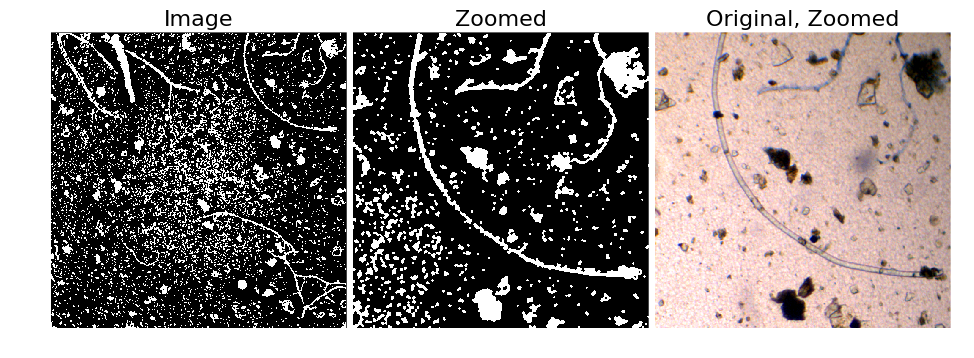

In [147]:




img = mask
pr.multi_image_plot([img, pr._zoom(img, **zoom), pr._zoom(image, **zoom)], ["Image", "Zoomed", "Original, Zoomed"])

## 5. Identify Noise Filtering Parameters
Pyroots provides two methods to filter noise:
1. By area
2. By connectivity to large objects
They should be run in that order.

The area function, ``pr.dirt_removal`` works by assuming that the tiny speckles you see in your thresholded image follow normal distributions centered around zero, similarly to noise in things like spectrophotometers. You set the "standard deviation" from zero that you will use as a minimum area threshold (in pixels) as noise. I recommend 4sigma, or a ~1/31600 chance of keeping something that isn't just noise.

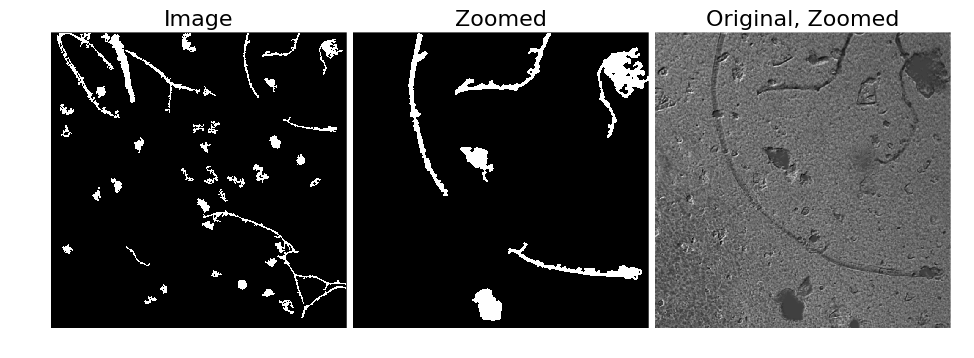

In [27]:
#################################################################################
filtering_params = [{'param' : 2}]
#################################################################################

no_dirt = pr.dirt_removal(mask, **filtering_params[0])

img = no_dirt
pr.multi_image_plot([img, pr._zoom(img, **zoom), pr._zoom(band, **zoom)], ["Image", "Zoomed", "Original, Zoomed"])

The second function, ``pr.noise_removal``, removes rough edges from objects. This makes skeletons cleaner. 

It first performs binary opening and closing to separate objects that are connected at corners, and then uses a median filter to smooth objects. By default, the binary operations use a square connectivity of 1 (manhattan = 1). The median filter uses a circular array giving euclidian distance < sqrt(2) pixels.

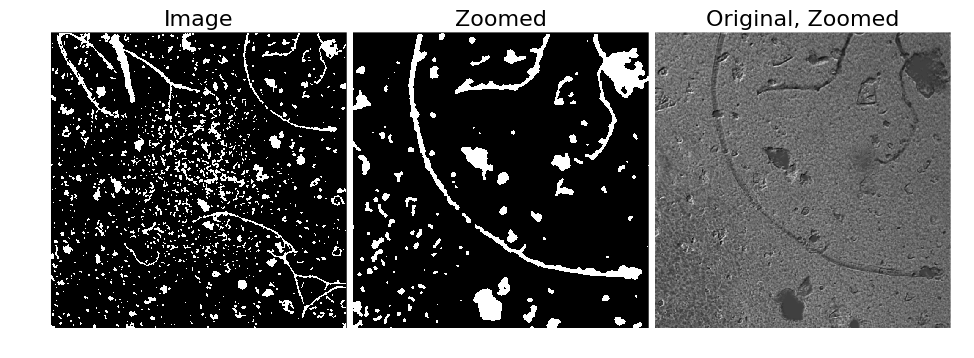

In [29]:
if len(filtering_params) < 2: filtering_params.append({}) # for convenient re-running

#################################################################################
filtering_params[1] = {'structure_1' : "Default",
                       'structure_2' : "Default",
                       "median_iterations" : 10}
#################################################################################

smoothed = pr.noise_removal(mask, **filtering_params[1])  

img = smoothed
pr.multi_image_plot([img, pr._zoom(img, **zoom), pr._zoom(band, **zoom)], ["Image", "Zoomed", "Original, Zoomed"])

## 6. Skeletonization
Now we can find the medial axis of each object, compute the diameter of the object at each point along that axis, and compute the length of each pixel on the axis.

Total Number of Objects: 72


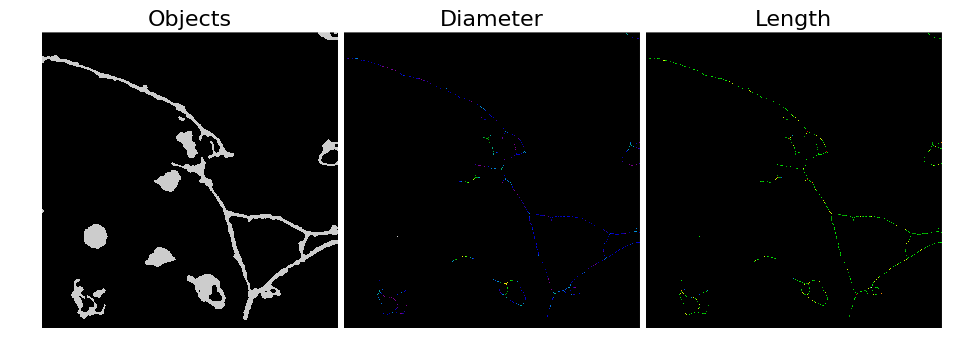

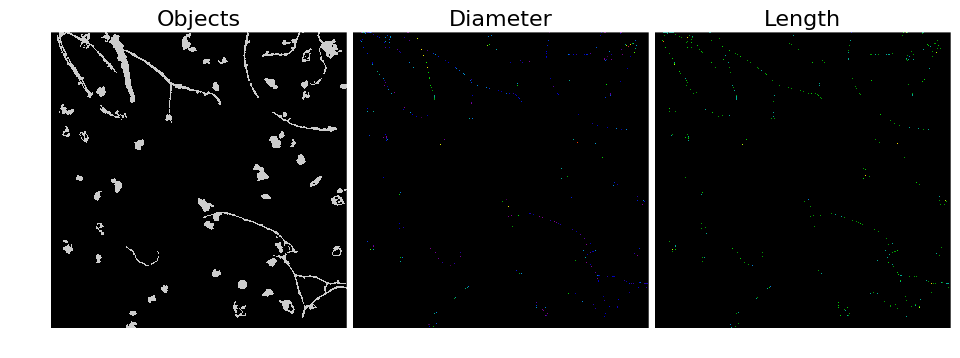

In [32]:
# Don't change anything here.
skel_dict = pr.skeleton_with_distance(smoothed)  # this function returns a dictionary of objects, similar to a named list in R

dictionary = skel_dict
print("Total Number of Objects: " + str(len(dictionary["geometry"])))

img_list = [dictionary["objects"], dictionary["diameter"], dictionary["length"]]
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img_list], ["Objects", "Diameter", "Length"], color_map = "spectral")
pr.multi_image_plot(img_list, ["Objects", "Diameter", "Length"], color_map = "spectral")

## 7. Set Geometry Filtering Parameters
With our initial geometry set, we can further filter objects by their shape. We'll do this in two steps:
1. A length:width filter
2. A diameter filter (if necessary)

#### Length-width filter
Besides the dictionary returned from skeletonization, the length:width filter requires a single parameter, `threshold`, that is the minimum length:width ratio for objects. It removes all objects that don't meet this threshold, and then updates the geometry dataframe and images.

Note: This function gives a warning that you can ignore.

/usr/lib/python3/dist-packages/pyroots/geometry_filters.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  geom_out.loc[0] = np.array([0,0])  # re-insert empty space index.


Total Number of Objects: 21


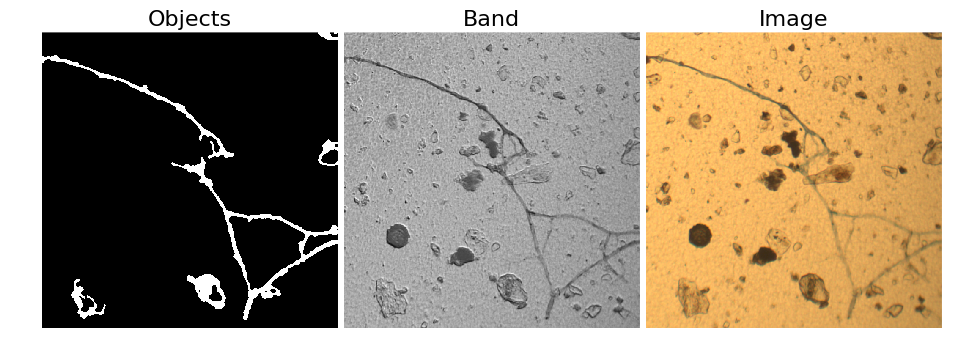

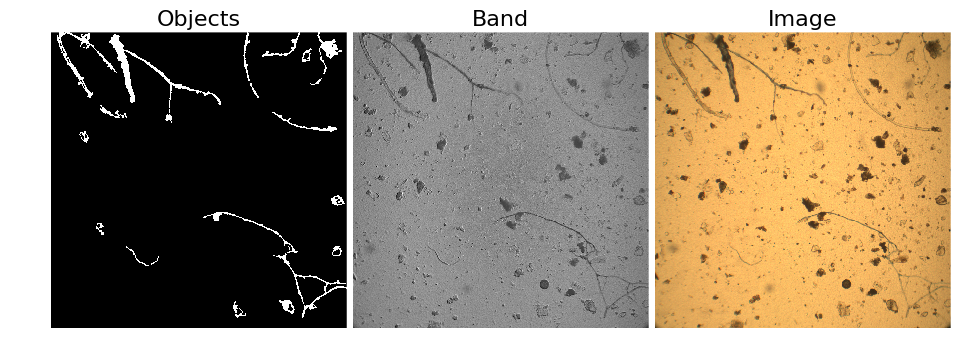

In [34]:
if len(filtering_params) < 3: filtering_params.append({}) # for convenience

#################################################################################
filtering_params[2] = {'threshold' : 10}
#################################################################################
# print(filtering_params[2])
lw_dict = pr.length_width_filter(skel_dict, **filtering_params[2])
# lw_dict

dictionary = lw_dict
print("Total Number of Objects: " + str(len(dictionary["geometry"])))

img_list = [dictionary["objects"], band[0], image]
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img_list], 
                    ["Objects", "Band", "Image"], color_map = "gray")
pr.multi_image_plot(img_list, ["Objects", "Band", "Image"], color_map = "gray")

#### Diameter Filter
The diameter filter works on the diameter skeleton has two possible outcomes:
1. Filtering objects that have a certain percentage of diameter-skeleton pixels higher/lower than a threshold
2. Filtering individual pixels in the diameter skeleton that are larger/smaller than a threshold.

Both of these outcomes are optional. Choose values based on your knowledge of your objects. For example, hyphae are generally less than 5 um in diameter; maize roots are rarely less than 20 um in diameter. 

### After running: Take a close look at your images. Did you capture you wanted and nothing else??

Total Number of Objects: 21


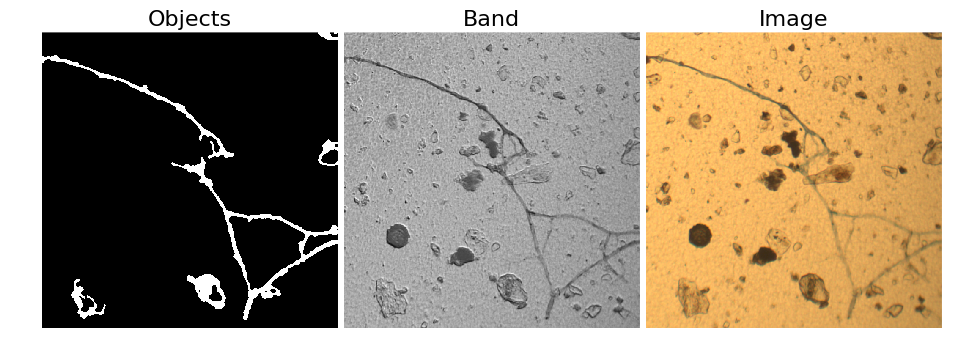

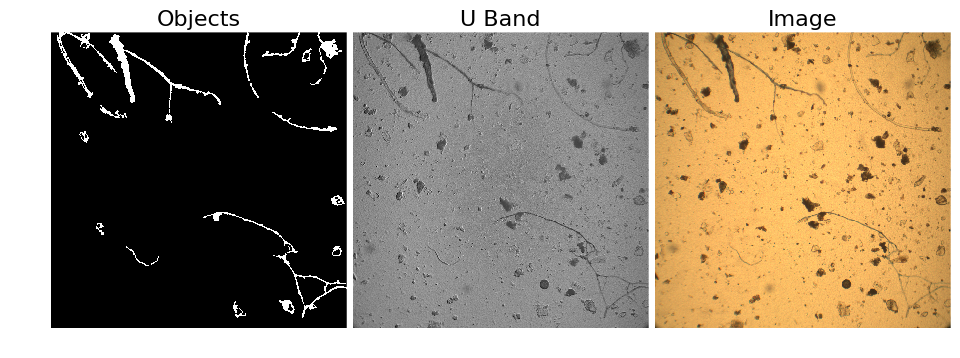

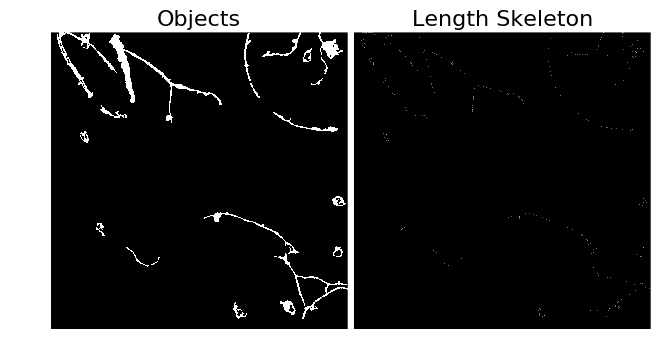

In [37]:
if len(filtering_params) < 4: filtering_params.append({}) # for convenience

#################################################################################
filtering_params[3] = {'max_diameter'   : 15,    # Pixels. Arbitrarily large to skip. Default = 10
                       'min_diameter'   : -1,     # Pixels. Negative to skip. Default = -1 (to skip)
                       'max_percentile' : 40,     # Percent. Removes entire objects where (100-%) pixels are wider than max_diameter. 100 skips. Default = 80
                       'min_percentile' : None}
#################################################################################

diameter_dict = pr.diameter_filter(lw_dict, **filtering_params[3])
# lw_dict

dictionary = diameter_dict
print("Total Number of Objects: " + str(len(dictionary["geometry"])))

img_list = [dictionary["objects"], band[0], image]
pr.multi_image_plot([pr._zoom(i, **zoom) for i in img_list], 
                    ["Objects", "Band", "Image"], color_map = "gray")
pr.multi_image_plot(img_list, ["Objects", "U Band", "Image"], color_map = "gray")
pr.multi_image_plot([dictionary["objects"], dictionary["length"]], ["Objects", "Length Skeleton"])

## Summarize